In [ ]:
# first I'll clac intersecting groups, then for all the groups I'll make the HR-HR plot

In [20]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups, calcIntersectionOfMultipleGroups, getHRsForTimePeriods, graphMultiHRDate, graphHypnoandHRDate
import pandas as pd


In [81]:
appleHRDf = getWorkingHRDfParquet('apple')
print(len(appleHRDf))
polarHRDf = getWorkingHRDfParquet('polar')
print(len(polarHRDf))
fitbitHRDf = getWorkingHRDfParquet('fitbit')
print(len(fitbitHRDf))

567895
1903183
16052785


In [90]:
#let's look at times that have samples 10 seconds or less apart
appleGroups = getHRGroups(appleHRDf, 20)
print(len(appleGroups))
polarGroups = getHRGroups(polarHRDf, 20)
print(len(polarGroups))
#fitbit takes like a minute to process
fitbitGroups = getHRGroups(fitbitHRDf, 20)
print(len(fitbitGroups))

663
79
24237


In [34]:
#I'd like to do some analysis on group lengths

In [91]:
intersectingGroups = pd.DataFrame(calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups]), columns = ['startDate', 'endDate'])
intersectingGroups['value'] = 1
print(len(intersectingGroups))


579


In [92]:
intersectingFitbitHRs = getHRsForTimePeriods(intersectingGroups, fitbitHRDf)
intersectingAppleHRs = getHRsForTimePeriods(intersectingGroups, appleHRDf)


In [93]:
print(len(intersectingFitbitHRs))
print(len(intersectingAppleHRs))


179752
241532


In [94]:
sorted(list(set(intersectingFitbitHRs.index.date)))[-10:]

[datetime.date(2024, 9, 8),
 datetime.date(2024, 9, 9),
 datetime.date(2024, 9, 10),
 datetime.date(2024, 9, 11),
 datetime.date(2024, 9, 12),
 datetime.date(2024, 9, 13),
 datetime.date(2024, 9, 14),
 datetime.date(2024, 9, 15),
 datetime.date(2024, 9, 16),
 datetime.date(2024, 9, 17)]

the day has 11116 samples for fitbit in 1 groups
the day has 11355 samples for apple in 5 groups


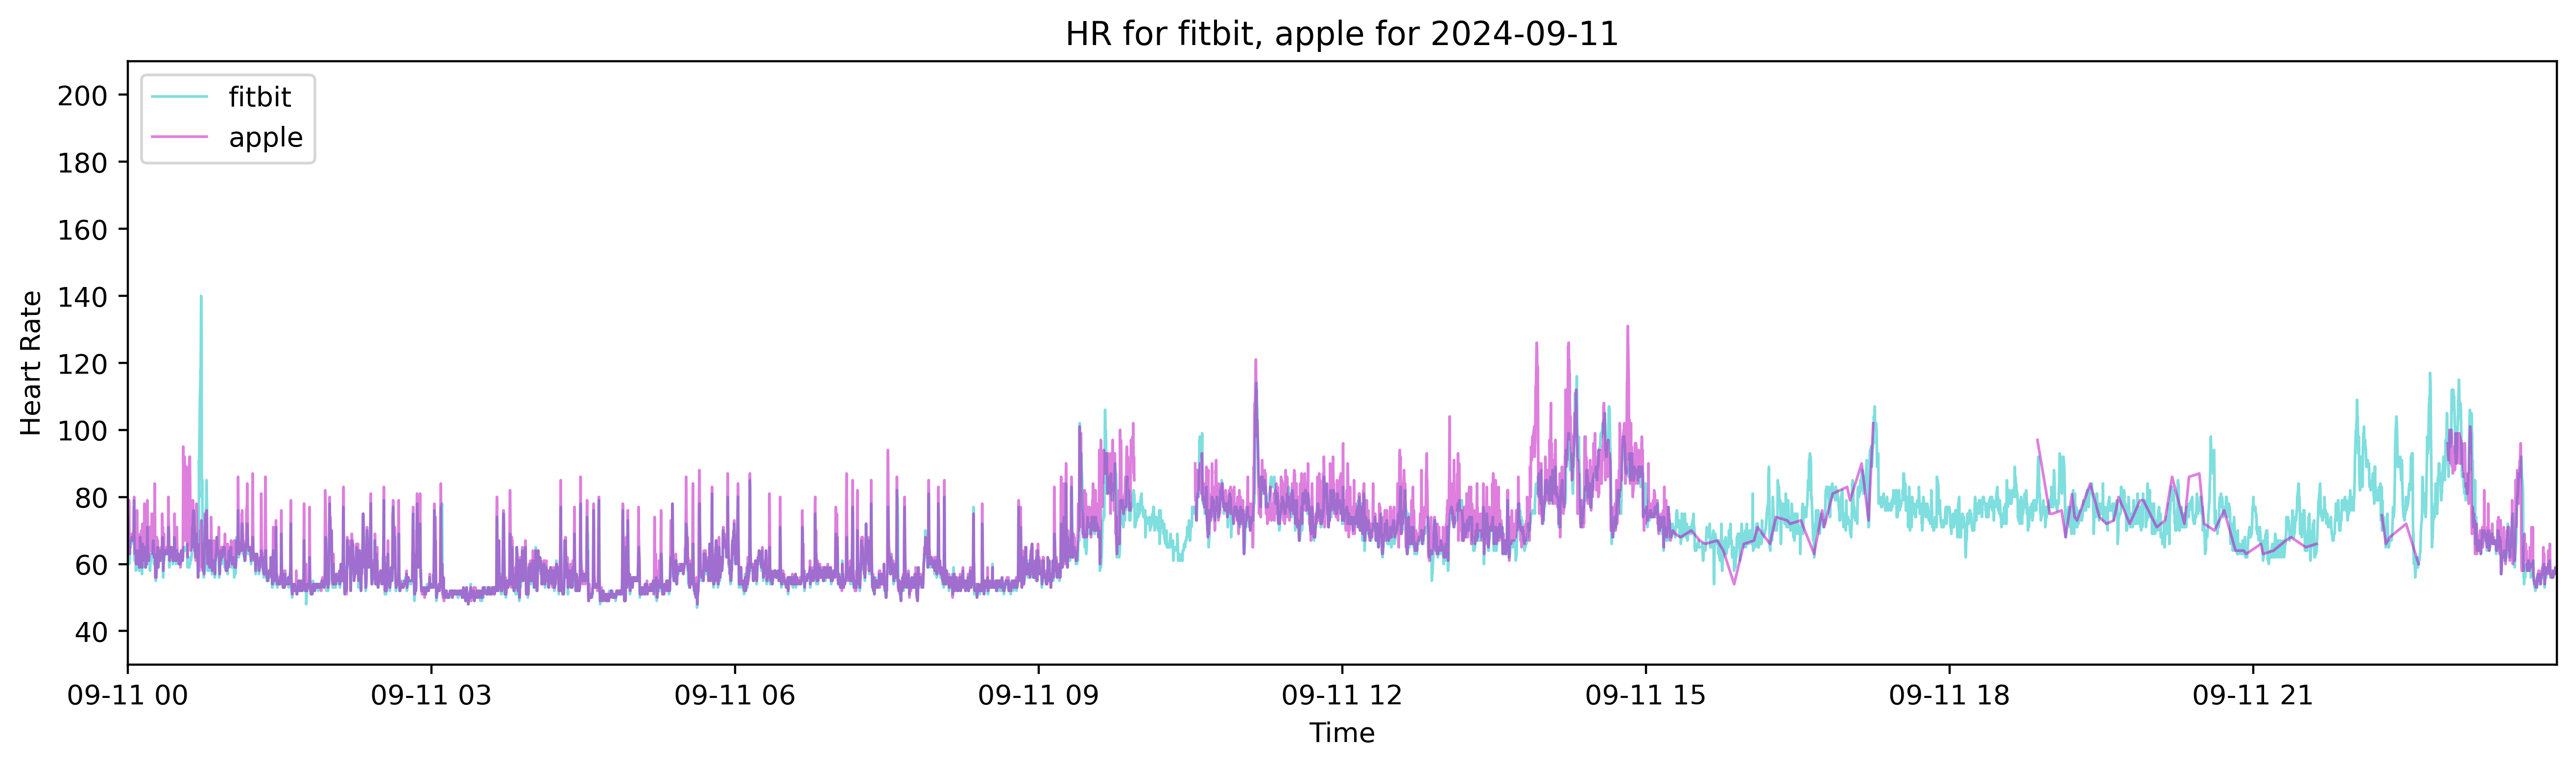

In [95]:
graphMultiHRDate([fitbitHRDf, appleHRDf], date(2024,9,11), ['fitbit','apple'], time(23,59,59))

the day has 11355 samples for apple in 5 groups


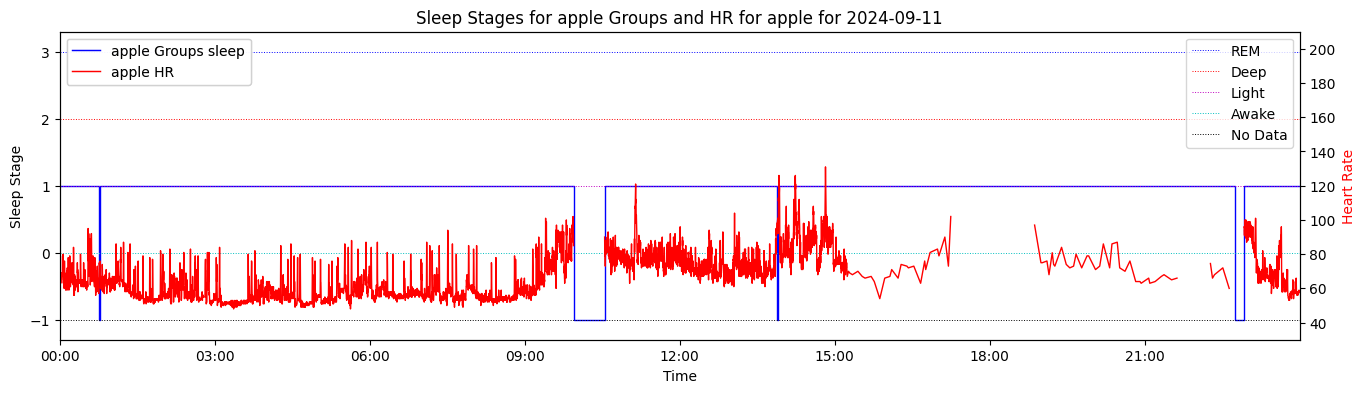

In [76]:
def makeHRGroupLikeHypno(hrGroups):
    data = [[group[0], group[1], 1] for group in hrGroups]
    #print(data)
    # add in the no data segments
    filledRecords = []
    # for every row except the last
    for ri in range(len(data)-1):
        filledRecords.append(data[ri])
        # if there is a gap between this rows end date and the next rows start date
        if data[ri][1] < data[ri+1][0]:
            filledRecords.append([
                data[ri][1],
                data[ri+1][0],
                -1
            ])
    filledRecords.append(data[-1])
    ColumnNames = ["startDate", "endDate", "value"]
    return pd.DataFrame(columns=ColumnNames, data=filledRecords)

graphHypnoandHRDate(makeHRGroupLikeHypno(appleGroups), appleHRDf, date(2024,9,11), 'apple Groups', 'apple', time(23,59,59))

In [88]:
def getHRGroups(series, maxDelta = 20, minGroupTime = pd.Timedelta(minutes=5)):
    time_diffs = series.index.to_series().diff()
    
    # Mark where the time difference exceeds the threshold (group break points)
    group_breaks = time_diffs.dt.total_seconds() > maxDelta
    
    # Assign group labels by cumulatively summing the group breaks
    group_labels = group_breaks.cumsum()

    # Group by the labels and extract the start and end times for each group
    grouped = series.groupby(group_labels)

    # Create a list of (start_time, end_time) for each group
    groups = [(group.index[0], group.index[-1]) for _, group in grouped]

    return [group for group in groups if group[1] - group[0] > minGroupTime]

/home/chowder/Documents/dataImport/utils.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 11355 samples for apple in 5 groups


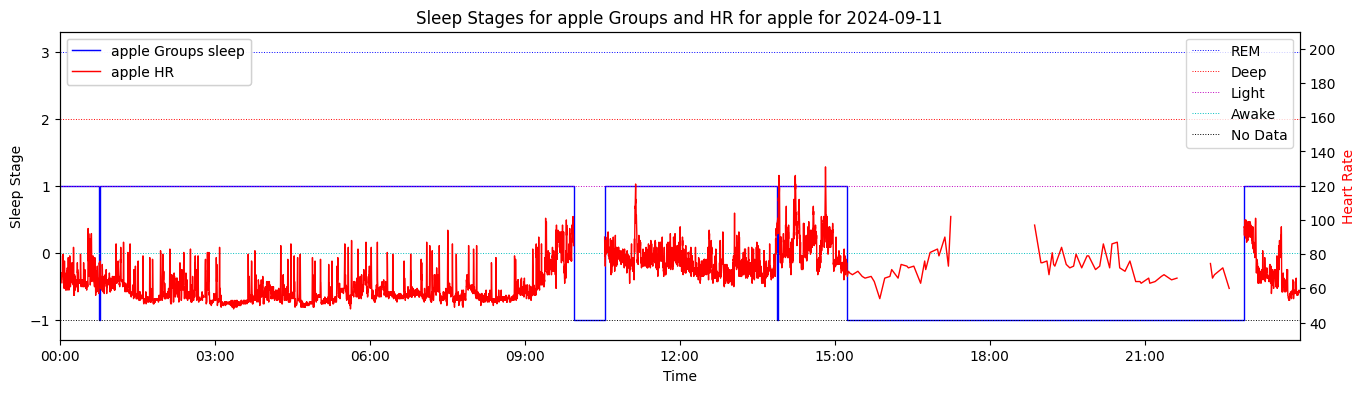

In [89]:
forDay = date(2024,9,11)
HRDfForDay = appleHRDf[appleHRDf.index.date == forDay]
groupsForDay = getHRGroups(HRDfForDay, 20)
graphHypnoandHRDate(makeHRGroupLikeHypno(groupsForDay), HRDfForDay, date(2024,9,11), 'apple Groups', 'apple', time(23,59,59))

In [75]:
forDay = date(2024,9,11)
HRDfForDay = appleHRDf[appleHRDf.index.date == forDay]
groupsForDay = getHRGroups(HRDfForDay, 20)
print(groupsForDay[-1])
makeHRGroupLikeHypno(groupsForDay)

[[Timestamp('2024-09-11 00:00:08-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 00:45:51-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 00:46:25-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 09:56:45-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 10:32:37-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 13:52:41-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 13:53:06-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 13:53:06-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 13:53:45-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 13:53:56-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 13:54:20-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 15:13:55-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 15:14:28-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-11 15:14:28-0700', tz='pytz.FixedOffset(-420)')], [Timestamp('2024-09-11 15:15:57-0

,startDate,endDate,value
0,2024-09-11 00:00:08-07:00,2024-09-11 00:45:51-07:00,1
1,2024-09-11 00:45:51-07:00,2024-09-11 00:46:25-07:00,-1
2,2024-09-11 00:46:25-07:00,2024-09-11 09:56:45-07:00,1
3,2024-09-11 09:56:45-07:00,2024-09-11 10:32:37-07:00,-1
4,2024-09-11 10:32:37-07:00,2024-09-11 13:52:41-07:00,1
5,2024-09-11 13:52:41-07:00,2024-09-11 13:54:20-07:00,-1
6,2024-09-11 13:54:20-07:00,2024-09-11 15:13:55-07:00,1
7,2024-09-11 15:13:55-07:00,2024-09-11 22:55:11-07:00,-1


/home/chowder/Documents/dataImport/utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 7220 samples for fitbit in 3 groups


/home/chowder/Documents/dataImport/utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 11267 samples for apple in 3 groups


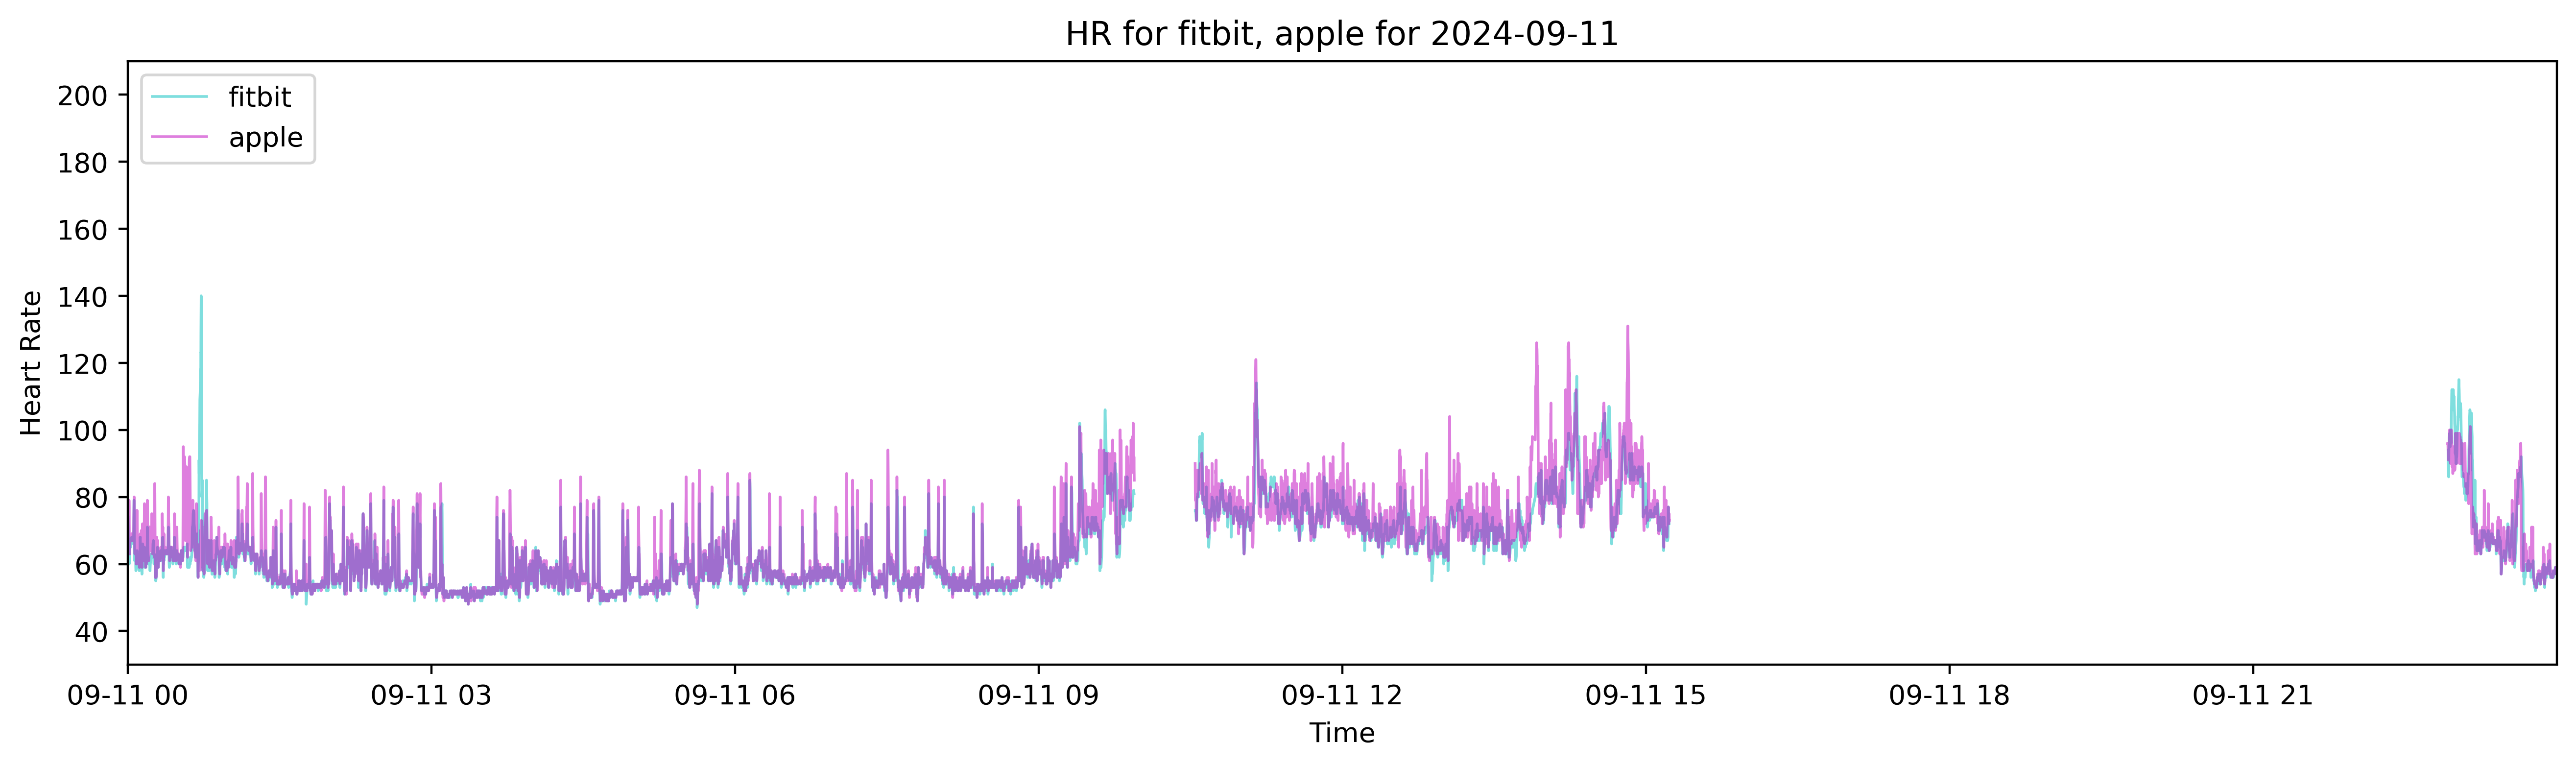

In [96]:
from datetime import date, time
graphMultiHRDate([intersectingFitbitHRs, intersectingAppleHRs], date(2024,9,11), ['fitbit','apple'], time(23,59,59))